# Session 6: Cross-Sectional Analysis

## Event Studies in Finance and Economics - Summer School

---

### Learning Objectives

By the end of this session, you will be able to:

1. Understand why cross-sectional variation in event responses matters
2. Implement cross-sectional regression analysis of CARs
3. Handle heteroskedasticity in cross-sectional regressions
4. Use weighted least squares (WLS) for efficient estimation
5. Analyze determinants of abnormal returns
6. Address endogeneity concerns in event study settings

---

## 1. Introduction: Beyond Average Effects

### From CAAR to Cross-Sectional Analysis

So far, we've focused on testing whether the **average** abnormal return differs from zero. But events often affect firms differently:

- **Earnings announcements**: Surprise magnitude matters
- **M&A announcements**: Deal characteristics affect returns
- **Regulatory changes**: Firm exposure varies
- **Macroeconomic shocks**: Industry and size matter

### The Cross-Sectional Regression

$$CAR_i = \alpha + \beta_1 X_{1i} + \beta_2 X_{2i} + ... + \beta_k X_{ki} + \epsilon_i$$

Where $X_{ji}$ are firm or event characteristics that may explain variation in abnormal returns.

### Key Questions

1. What firm characteristics predict stronger/weaker event responses?
2. Do deal characteristics affect announcement returns?
3. How does prior information affect the market reaction?
4. Are there systematic patterns across industries or time?

## 2. Setup and Data

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import yfinance as yf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from datetime import timedelta
from dataclasses import dataclass
from typing import List, Dict, Optional, Tuple
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
print("Libraries loaded!")

Libraries loaded!


In [5]:
# Extended sample with firm characteristics for cross-sectional analysis
# Using Q2-Q3 2023 earnings announcements with additional firm data
EVENTS = [
    # Tech - Large Cap
    {'ticker': 'AAPL', 'date': '2023-08-03', 'name': 'Apple', 'sector': 'Tech', 'eps_surprise': 0.05},
    {'ticker': 'MSFT', 'date': '2023-07-25', 'name': 'Microsoft', 'sector': 'Tech', 'eps_surprise': 0.08},
    {'ticker': 'GOOGL', 'date': '2023-07-25', 'name': 'Alphabet', 'sector': 'Tech', 'eps_surprise': 0.12},
    {'ticker': 'AMZN', 'date': '2023-08-03', 'name': 'Amazon', 'sector': 'Tech', 'eps_surprise': 0.45},
    {'ticker': 'META', 'date': '2023-07-26', 'name': 'Meta', 'sector': 'Tech', 'eps_surprise': 0.22},
    {'ticker': 'NVDA', 'date': '2023-08-23', 'name': 'Nvidia', 'sector': 'Tech', 'eps_surprise': 0.35},
    # Tech - Smaller
    {'ticker': 'AMD', 'date': '2023-08-01', 'name': 'AMD', 'sector': 'Tech', 'eps_surprise': -0.02},
    {'ticker': 'INTC', 'date': '2023-07-27', 'name': 'Intel', 'sector': 'Tech', 'eps_surprise': 0.18},
    {'ticker': 'CRM', 'date': '2023-08-30', 'name': 'Salesforce', 'sector': 'Tech', 'eps_surprise': 0.15},
    {'ticker': 'ADBE', 'date': '2023-09-14', 'name': 'Adobe', 'sector': 'Tech', 'eps_surprise': 0.06},
    # Finance
    {'ticker': 'JPM', 'date': '2023-07-14', 'name': 'JPMorgan', 'sector': 'Finance', 'eps_surprise': 0.10},
    {'ticker': 'BAC', 'date': '2023-07-18', 'name': 'Bank of America', 'sector': 'Finance', 'eps_surprise': 0.03},
    {'ticker': 'WFC', 'date': '2023-07-14', 'name': 'Wells Fargo', 'sector': 'Finance', 'eps_surprise': 0.08},
    {'ticker': 'GS', 'date': '2023-07-19', 'name': 'Goldman Sachs', 'sector': 'Finance', 'eps_surprise': -0.15},
    {'ticker': 'MS', 'date': '2023-07-18', 'name': 'Morgan Stanley', 'sector': 'Finance', 'eps_surprise': -0.05},
    # Healthcare
    {'ticker': 'JNJ', 'date': '2023-07-20', 'name': 'Johnson & Johnson', 'sector': 'Healthcare', 'eps_surprise': 0.04},
    {'ticker': 'UNH', 'date': '2023-07-14', 'name': 'UnitedHealth', 'sector': 'Healthcare', 'eps_surprise': 0.02},
    {'ticker': 'PFE', 'date': '2023-08-01', 'name': 'Pfizer', 'sector': 'Healthcare', 'eps_surprise': -0.08},
    {'ticker': 'MRK', 'date': '2023-07-27', 'name': 'Merck', 'sector': 'Healthcare', 'eps_surprise': 0.12},
    {'ticker': 'ABBV', 'date': '2023-07-27', 'name': 'AbbVie', 'sector': 'Healthcare', 'eps_surprise': 0.05},
    # Consumer
    {'ticker': 'PG', 'date': '2023-07-28', 'name': 'Procter & Gamble', 'sector': 'Consumer', 'eps_surprise': 0.03},
    {'ticker': 'KO', 'date': '2023-07-26', 'name': 'Coca-Cola', 'sector': 'Consumer', 'eps_surprise': 0.05},
    {'ticker': 'PEP', 'date': '2023-07-13', 'name': 'PepsiCo', 'sector': 'Consumer', 'eps_surprise': 0.07},
    {'ticker': 'WMT', 'date': '2023-08-17', 'name': 'Walmart', 'sector': 'Consumer', 'eps_surprise': 0.09},
    {'ticker': 'COST', 'date': '2023-09-26', 'name': 'Costco', 'sector': 'Consumer', 'eps_surprise': 0.04},
]

EST_WINDOW, GAP, PRE, POST = 120, 10, 5, 5
print(f"Sample: {len(EVENTS)} earnings announcements across {len(set(e['sector'] for e in EVENTS))} sectors")

Sample: 25 earnings announcements across 4 sectors


In [7]:
@dataclass
class EventResult:
    """Container for event study results with firm characteristics."""
    ticker: str
    name: str
    sector: str
    event_date: pd.Timestamp
    eps_surprise: float
    market_cap: float
    beta: float
    sigma: float
    pre_event_return: float
    event_data: pd.DataFrame
    car_var: float  # Variance of CAR for WLS


def get_firm_characteristics(ticker: str) -> Dict:
    """Fetch firm characteristics from Yahoo Finance."""
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        return {
            'market_cap': info.get('marketCap', np.nan),
            'beta': info.get('beta', np.nan),
        }
    except:
        return {'market_cap': np.nan, 'beta': np.nan}


def process_event(event: Dict, est_window: int, gap: int, pre: int, post: int) -> Optional[EventResult]:
    """Process single event and extract characteristics."""
    try:
        ticker = event['ticker']
        event_dt = pd.to_datetime(event['date'])
        start = event_dt - timedelta(days=int((est_window + gap + pre) * 1.5))
        end = event_dt + timedelta(days=int(post * 2.5))
        
        stock = yf.download(ticker, start=start, end=end, progress=False)['Close']
        market = yf.download('^GSPC', start=start, end=end, progress=False)['Close']
        
        df = pd.DataFrame({'stock': stock.squeeze(), 'market': market.squeeze()})
        df['stock_ret'] = df['stock'].pct_change()
        df['market_ret'] = df['market'].pct_change()
        df = df.dropna()
        
        if event_dt not in df.index:
            idx = df.index.get_indexer([event_dt], method='nearest')[0]
            event_dt = df.index[idx]
        
        event_idx = df.index.get_loc(event_dt)
        df['event_time'] = range(-event_idx, len(df) - event_idx)
        
        # Split windows
        est_end = -(gap + pre)
        est_data = df[(df['event_time'] >= est_end - est_window) & (df['event_time'] < est_end)]
        evt_data = df[(df['event_time'] >= -pre) & (df['event_time'] <= post)].copy()
        
        # Market model estimation
        y, x = est_data['stock_ret'].values, est_data['market_ret'].values
        X = sm.add_constant(x)
        ols = sm.OLS(y, X).fit()
        
        alpha, beta = ols.params[0], ols.params[1]
        sigma = np.std(ols.resid, ddof=2)
        
        # Abnormal returns
        evt_data['expected'] = alpha + beta * evt_data['market_ret']
        evt_data['AR'] = evt_data['stock_ret'] - evt_data['expected']
        
        # Pre-event cumulative return (momentum proxy)
        pre_event_data = df[(df['event_time'] >= -60) & (df['event_time'] < -pre)]
        pre_event_return = (1 + pre_event_data['stock_ret']).prod() - 1 if len(pre_event_data) > 0 else 0
        
        # CAR variance for WLS
        L = len(evt_data[(evt_data['event_time'] >= -1) & (evt_data['event_time'] <= 1)])
        car_var = L * sigma**2
        
        # Get firm characteristics
        chars = get_firm_characteristics(ticker)
        
        return EventResult(
            ticker=ticker,
            name=event['name'],
            sector=event['sector'],
            event_date=event_dt,
            eps_surprise=event['eps_surprise'],
            market_cap=chars['market_cap'],
            beta=beta,
            sigma=sigma,
            pre_event_return=pre_event_return,
            event_data=evt_data,
            car_var=car_var
        )
    except Exception as e:
        print(f"{event['ticker']}: FAILED - {e}")
        return None


print("Processing events...")
event_results = [r for e in EVENTS if (r := process_event(e, EST_WINDOW, GAP, PRE, POST))]
print(f"Successfully processed {len(event_results)} events")

Processing events...
YF.download() has changed argument auto_adjust default to True
Successfully processed 25 events


In [8]:
def calculate_car(event_data: pd.DataFrame, tau1: int, tau2: int) -> float:
    mask = (event_data['event_time'] >= tau1) & (event_data['event_time'] <= tau2)
    return event_data.loc[mask, 'AR'].sum()


# Create cross-sectional dataset
def create_cross_sectional_data(event_results: List[EventResult], tau1: int, tau2: int) -> pd.DataFrame:
    """Create dataset for cross-sectional regression."""
    data = []
    for r in event_results:
        car = calculate_car(r.event_data, tau1, tau2)
        data.append({
            'ticker': r.ticker,
            'name': r.name,
            'sector': r.sector,
            'CAR': car,
            'eps_surprise': r.eps_surprise,
            'log_mcap': np.log(r.market_cap) if r.market_cap and r.market_cap > 0 else np.nan,
            'beta': r.beta,
            'sigma': r.sigma,
            'momentum': r.pre_event_return,
            'car_var': r.car_var,
            'car_se': np.sqrt(r.car_var)
        })
    
    df = pd.DataFrame(data)
    df = df.dropna()
    return df


# Create dataset for CAR(-1,+1)
cs_data = create_cross_sectional_data(event_results, -1, 1)
print(f"\nCross-sectional dataset: {len(cs_data)} observations")
print(cs_data[['ticker', 'sector', 'CAR', 'eps_surprise', 'log_mcap']].head(10).to_string())


Cross-sectional dataset: 24 observations
  ticker sector       CAR  eps_surprise   log_mcap
0   AAPL   Tech -0.051469          0.05  28.931133
1   MSFT   Tech -0.031932          0.08  28.840995
2  GOOGL   Tech  0.062735          0.12  29.018200
3   AMZN   Tech  0.090422          0.45  28.549368
4   META   Tech  0.060857          0.22  28.121054
5   NVDA   Tech -0.000214          0.35  29.135165
6    AMD   Tech -0.011225         -0.02  26.746914
7   INTC   Tech  0.075252          0.18  26.280505
8    CRM   Tech  0.023052          0.15  26.103816
9   ADBE   Tech -0.026877          0.06  25.555308


## 3. Exploratory Analysis

In [11]:
# Summary statistics by sector
print("Summary Statistics by Sector:")
print("="*70)

sector_stats = cs_data.groupby('sector').agg({
    'CAR': ['count', 'mean', 'median', 'std'],
    'eps_surprise': 'mean',
    'log_mcap': 'mean'
}).round(4)

sector_stats.columns = ['N', 'Mean CAR', 'Median CAR', 'Std CAR', 'Avg EPS Surp', 'Avg Log MCap']
sector_stats['Mean CAR'] = sector_stats['Mean CAR'].apply(lambda x: f"{x*100:.2f}%")
sector_stats['Median CAR'] = sector_stats['Median CAR'].apply(lambda x: f"{x*100:.2f}%")
sector_stats['Std CAR'] = sector_stats['Std CAR'].apply(lambda x: f"{x*100:.2f}%")
print(sector_stats.to_string())

Summary Statistics by Sector:
             N Mean CAR Median CAR Std CAR  Avg EPS Surp  Avg Log MCap
sector                                                                
Consumer     5    0.91%      1.42%   1.03%         0.056       26.6830
Finance      4    4.86%      4.89%   2.81%         0.015       26.7116
Healthcare   5    3.91%      6.73%   4.37%         0.030       26.4434
Tech        10    1.91%      1.14%   5.04%         0.164       27.7282


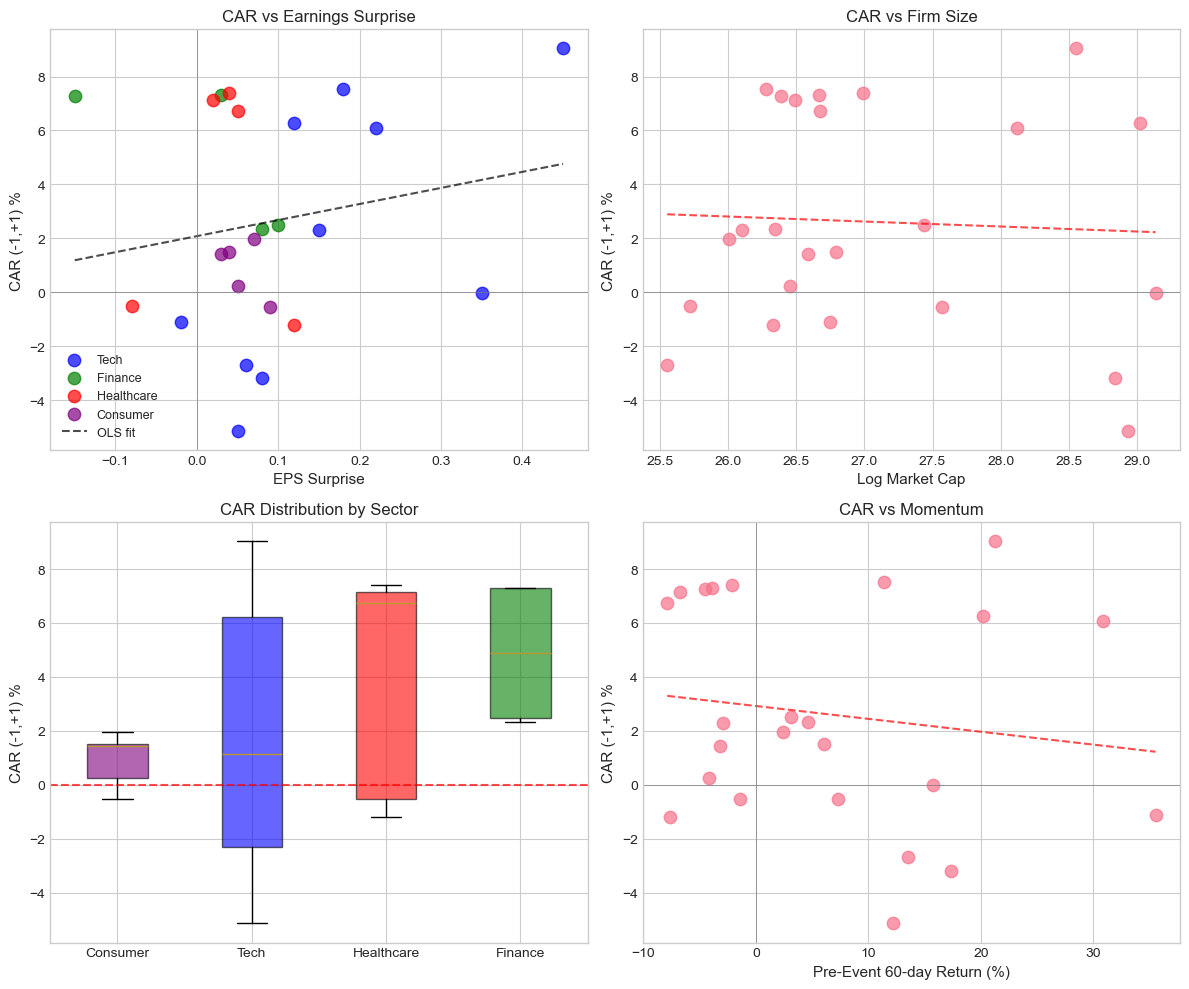

In [15]:
# Visualize relationships
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# CAR vs EPS Surprise
ax1 = axes[0, 0]
colors = {'Tech': 'blue', 'Finance': 'green', 'Healthcare': 'red', 'Consumer': 'purple'}
for sector in cs_data['sector'].unique():
    mask = cs_data['sector'] == sector
    ax1.scatter(cs_data.loc[mask, 'eps_surprise'], cs_data.loc[mask, 'CAR']*100, 
                label=sector, alpha=0.7, s=80, c=colors.get(sector, 'gray'))

# Add regression line
z = np.polyfit(cs_data['eps_surprise'], cs_data['CAR']*100, 1)
p = np.poly1d(z)
x_line = np.linspace(cs_data['eps_surprise'].min(), cs_data['eps_surprise'].max(), 100)
ax1.plot(x_line, p(x_line), 'k--', alpha=0.7, label='OLS fit')

ax1.set_xlabel('EPS Surprise', fontsize=11)
ax1.set_ylabel('CAR (-1,+1) %', fontsize=11)
ax1.set_title('CAR vs Earnings Surprise', fontsize=12)
ax1.axhline(0, color='gray', linestyle='-', linewidth=0.5)
ax1.axvline(0, color='gray', linestyle='-', linewidth=0.5)
ax1.legend(fontsize=9)

# CAR vs Market Cap
ax2 = axes[0, 1]
ax2.scatter(cs_data['log_mcap'], cs_data['CAR']*100, alpha=0.7, s=80)
z = np.polyfit(cs_data['log_mcap'], cs_data['CAR']*100, 1)
p = np.poly1d(z)
x_line = np.linspace(cs_data['log_mcap'].min(), cs_data['log_mcap'].max(), 100)
ax2.plot(x_line, p(x_line), 'r--', alpha=0.7)
ax2.set_xlabel('Log Market Cap', fontsize=11)
ax2.set_ylabel('CAR (-1,+1) %', fontsize=11)
ax2.set_title('CAR vs Firm Size', fontsize=12)
ax2.axhline(0, color='gray', linestyle='-', linewidth=0.5)

# CAR distribution by sector
ax3 = axes[1, 0]
sector_order = cs_data.groupby('sector')['CAR'].mean().sort_values().index
cs_data['sector_cat'] = pd.Categorical(cs_data['sector'], categories=sector_order, ordered=True)
bp = ax3.boxplot([cs_data[cs_data['sector'] == s]['CAR']*100 for s in sector_order],
                  labels=sector_order, patch_artist=True)
for patch, sector in zip(bp['boxes'], sector_order):
    patch.set_facecolor(colors.get(sector, 'gray'))
    patch.set_alpha(0.6)
ax3.axhline(0, color='red', linestyle='--', alpha=0.7)
ax3.set_ylabel('CAR (-1,+1) %', fontsize=11)
ax3.set_title('CAR Distribution by Sector', fontsize=12)

# CAR vs Pre-event Momentum
ax4 = axes[1, 1]
ax4.scatter(cs_data['momentum']*100, cs_data['CAR']*100, alpha=0.7, s=80)
z = np.polyfit(cs_data['momentum']*100, cs_data['CAR']*100, 1)
p = np.poly1d(z)
x_line = np.linspace(cs_data['momentum'].min()*100, cs_data['momentum'].max()*100, 100)
ax4.plot(x_line, p(x_line), 'r--', alpha=0.7)
ax4.set_xlabel('Pre-Event 60-day Return (%)', fontsize=11)
ax4.set_ylabel('CAR (-1,+1) %', fontsize=11)
ax4.set_title('CAR vs Momentum', fontsize=12)
ax4.axhline(0, color='gray', linestyle='-', linewidth=0.5)
ax4.axvline(0, color='gray', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

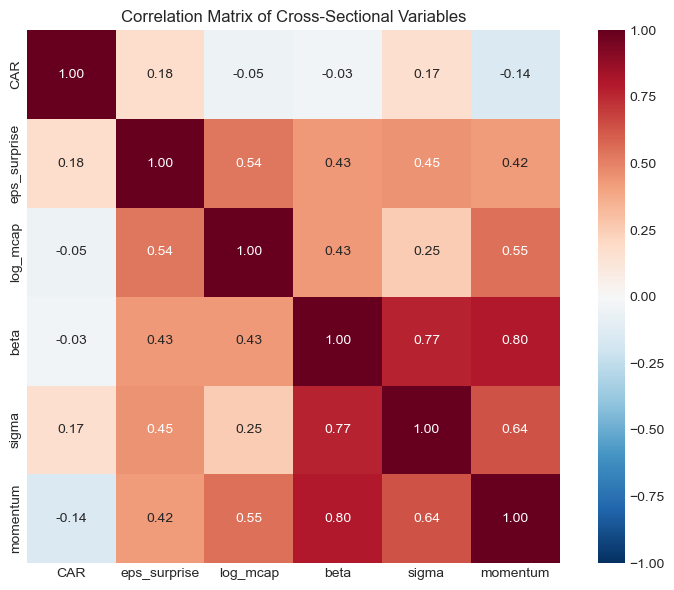

In [17]:
# Correlation matrix
corr_vars = ['CAR', 'eps_surprise', 'log_mcap', 'beta', 'sigma', 'momentum']
corr_matrix = cs_data[corr_vars].corr()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            vmin=-1, vmax=1, ax=ax, square=True)
ax.set_title('Correlation Matrix of Cross-Sectional Variables', fontsize=12)
plt.tight_layout()
plt.show()

## 4. Basic OLS Cross-Sectional Regression

### Model Specification

$$CAR_i = \alpha + \beta_1 \cdot EPS\_Surprise_i + \beta_2 \cdot \ln(MCap)_i + \beta_3 \cdot Momentum_i + \epsilon_i$$

### Interpretation

- $\beta_1$: Effect of 1 unit increase in EPS surprise on CAR
- $\beta_2$: Size effect (do larger firms react differently?)
- $\beta_3$: Momentum effect (does prior return predict event response?)

In [20]:
def run_cross_sectional_regression(data: pd.DataFrame, 
                                    y_var: str, 
                                    x_vars: List[str],
                                    add_constant: bool = True) -> sm.regression.linear_model.RegressionResultsWrapper:
    """Run OLS cross-sectional regression."""
    y = data[y_var]
    X = data[x_vars]
    
    if add_constant:
        X = sm.add_constant(X)
    
    model = sm.OLS(y, X).fit()
    return model


# Model 1: Simple - EPS Surprise only
print("="*80)
print("MODEL 1: CAR on EPS Surprise")
print("="*80)

model1 = run_cross_sectional_regression(cs_data, 'CAR', ['eps_surprise'])
print(model1.summary())

MODEL 1: CAR on EPS Surprise
                            OLS Regression Results                            
Dep. Variable:                    CAR   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                    0.7415
Date:                Fri, 23 Jan 2026   Prob (F-statistic):              0.398
Time:                        14:23:42   Log-Likelihood:                 43.686
No. Observations:                  24   AIC:                            -83.37
Df Residuals:                      22   BIC:                            -81.02
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.

In [22]:
# Model 2: Add firm characteristics
print("\n" + "="*80)
print("MODEL 2: CAR on EPS Surprise + Firm Characteristics")
print("="*80)

model2 = run_cross_sectional_regression(cs_data, 'CAR', 
                                         ['eps_surprise', 'log_mcap', 'momentum'])
print(model2.summary())


MODEL 2: CAR on EPS Surprise + Firm Characteristics
                            OLS Regression Results                            
Dep. Variable:                    CAR   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                 -0.038
Method:                 Least Squares   F-statistic:                    0.7205
Date:                Fri, 23 Jan 2026   Prob (F-statistic):              0.551
Time:                        14:23:43   Log-Likelihood:                 44.520
No. Observations:                  24   AIC:                            -81.04
Df Residuals:                      20   BIC:                            -76.33
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

In [26]:
# Model 3: Add sector fixed effects
print("\n" + "="*80)
print("MODEL 3: With Sector Fixed Effects")
print("="*80)

# Create sector dummies
cs_data_fe = cs_data.copy()
sector_dummies = pd.get_dummies(cs_data_fe['sector'], prefix='sector', drop_first=True)
cs_data_fe = pd.concat([cs_data_fe, sector_dummies], axis=1)

x_vars_fe = ['eps_surprise', 'log_mcap', 'momentum'] + list(sector_dummies.columns)
model3 = run_cross_sectional_regression(cs_data_fe, 'CAR', x_vars_fe)
print(model3.summary())


MODEL 3: With Sector Fixed Effects


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [75]:
 ['eps_surprise', 'log_mcap', 'momentum'] + list(sector_dummies.columns)

['eps_surprise',
 'log_mcap',
 'momentum',
 'sector_Finance',
 'sector_Healthcare',
 'sector_Tech']

## 5. Heteroskedasticity and Robust Standard Errors

### The Problem

In event studies, $Var(CAR_i)$ varies across firms:
- Firms with higher idiosyncratic volatility ($\sigma_i$) have noisier CARs
- This violates the OLS assumption of homoskedasticity

### Testing for Heteroskedasticity

1. **Breusch-Pagan test**: Tests if variance depends on regressors
2. **White test**: More general test for heteroskedasticity

### Solutions

1. **Robust standard errors** (White, 1980): Correct SEs without changing coefficients
2. **Weighted Least Squares (WLS)**: Weight by inverse variance for efficiency

In [30]:
# Test for heteroskedasticity
print("Heteroskedasticity Tests:")
print("="*60)

# Get residuals from Model 2
y = cs_data['CAR']
X = sm.add_constant(cs_data[['eps_surprise', 'log_mcap', 'momentum']])

# Breusch-Pagan test
bp_lm, bp_pval, bp_f, bp_fpval = het_breuschpagan(model2.resid, X)
print(f"\nBreusch-Pagan Test:")
print(f"  LM statistic: {bp_lm:.4f}")
print(f"  p-value: {bp_pval:.4f}")
print(f"  Conclusion: {'Reject H0 - Heteroskedasticity present' if bp_pval < 0.05 else 'Fail to reject H0'}")

# White test
white_lm, white_pval, white_f, white_fpval = het_white(model2.resid, X)
print(f"\nWhite Test:")
print(f"  LM statistic: {white_lm:.4f}")
print(f"  p-value: {white_pval:.4f}")
print(f"  Conclusion: {'Reject H0 - Heteroskedasticity present' if white_pval < 0.05 else 'Fail to reject H0'}")

Heteroskedasticity Tests:

Breusch-Pagan Test:
  LM statistic: 3.9217
  p-value: 0.2700
  Conclusion: Fail to reject H0

White Test:
  LM statistic: 16.9926
  p-value: 0.0488
  Conclusion: Reject H0 - Heteroskedasticity present


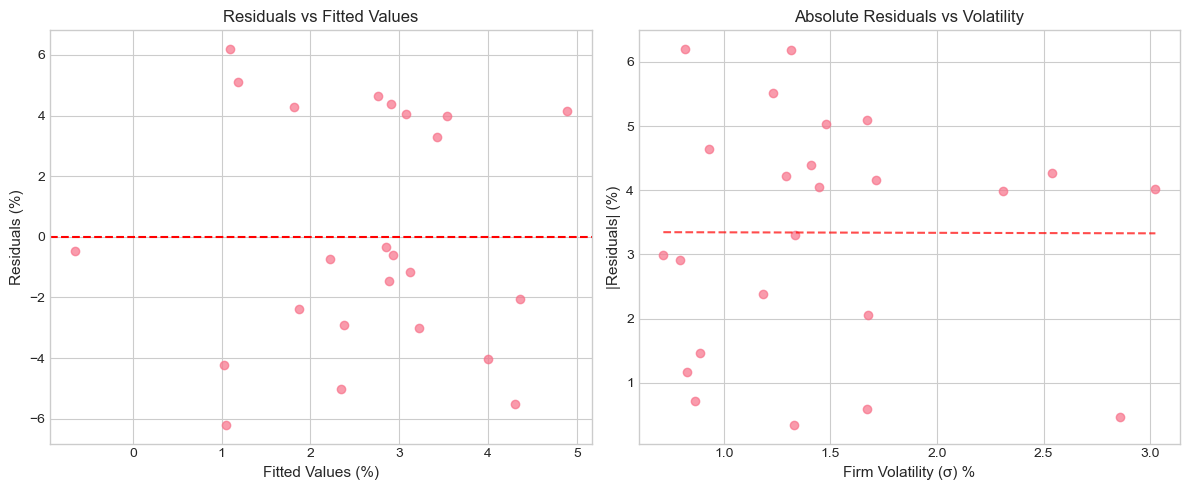


Note: If residuals spread out with volatility, we have heteroskedasticity.


In [32]:
# Visualize heteroskedasticity
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Residuals vs Fitted
ax1 = axes[0]
ax1.scatter(model2.fittedvalues*100, model2.resid*100, alpha=0.7)
ax1.axhline(0, color='red', linestyle='--')
ax1.set_xlabel('Fitted Values (%)', fontsize=11)
ax1.set_ylabel('Residuals (%)', fontsize=11)
ax1.set_title('Residuals vs Fitted Values', fontsize=12)

# Residuals vs Sigma (proxy for heteroskedasticity)
ax2 = axes[1]
ax2.scatter(cs_data['sigma']*100, np.abs(model2.resid)*100, alpha=0.7)
z = np.polyfit(cs_data['sigma']*100, np.abs(model2.resid)*100, 1)
p = np.poly1d(z)
x_line = np.linspace(cs_data['sigma'].min()*100, cs_data['sigma'].max()*100, 100)
ax2.plot(x_line, p(x_line), 'r--', alpha=0.7)
ax2.set_xlabel('Firm Volatility (σ) %', fontsize=11)
ax2.set_ylabel('|Residuals| (%)', fontsize=11)
ax2.set_title('Absolute Residuals vs Volatility', fontsize=12)

plt.tight_layout()
plt.show()

print("\nNote: If residuals spread out with volatility, we have heteroskedasticity.")

In [38]:
# Compare OLS with Robust Standard Errors
print("\n" + "="*80)
print("COMPARISON: OLS vs Robust Standard Errors")
print("="*80)

# OLS with robust SEs (HC1 = White's heteroskedasticity-consistent)
model2_robust = run_cross_sectional_regression(cs_data, 'CAR', 
                                                ['eps_surprise', 'log_mcap', 'momentum'])
model2_robust_hc = model2_robust.get_robustcov_results(cov_type='HC1')

# Create comparison table
comparison = pd.DataFrame({
    'Variable': model2.params.index,
    'Coef': model2.params.values,
    'OLS SE': model2.bse.values,
    'OLS t-stat': model2.tvalues.values,
    'Robust SE': model2_robust_hc.bse,
    'Robust t-stat': model2_robust_hc.tvalues,
})

comparison['SE Change'] = (comparison['Robust SE'] / comparison['OLS SE'] - 1) * 100

print("\nCoefficient Comparison:")
for col in ['Coef', 'OLS SE', 'Robust SE']:
    comparison[col] = comparison[col].apply(lambda x: f"{x:.6f}")
for col in ['OLS t-stat', 'Robust t-stat']:
    comparison[col] = comparison[col].apply(lambda x: f"{x:.3f}")
comparison['SE Change'] = comparison['SE Change'].apply(lambda x: f"{x:+.1f}%")

print(comparison.to_string(index=False))
print("\nNote: Positive SE Change means robust SEs are larger (more conservative).")


COMPARISON: OLS vs Robust Standard Errors

Coefficient Comparison:
    Variable      Coef   OLS SE OLS t-stat Robust SE Robust t-stat SE Change
       const  0.123684 0.271768      0.455  0.324222         0.381    +19.3%
eps_surprise  0.109478 0.084438      1.297  0.098625         1.110    +16.8%
    log_mcap -0.003781 0.010230     -0.370  0.012309        -0.307    +20.3%
    momentum -0.075711 0.086403     -0.876  0.072240        -1.048    -16.4%

Note: Positive SE Change means robust SEs are larger (more conservative).


## 6. Weighted Least Squares (WLS)

### Motivation

When we know the variance structure, WLS is more efficient than OLS with robust SEs.

### Weights in Event Studies

Natural weight: inverse of CAR variance

$$w_i = \frac{1}{Var(CAR_i)} = \frac{1}{L \cdot \sigma^2_i}$$

Where $L$ is the event window length and $\sigma_i$ is firm i's residual volatility.

### WLS Estimator

$$\hat{\beta}_{WLS} = (X'WX)^{-1}X'Wy$$

Where $W = diag(w_1, ..., w_N)$

In [40]:
def run_wls_regression(data: pd.DataFrame, 
                       y_var: str, 
                       x_vars: List[str],
                       weight_var: str) -> sm.regression.linear_model.RegressionResultsWrapper:
    """Run Weighted Least Squares regression."""
    y = data[y_var]
    X = sm.add_constant(data[x_vars])
    
    # Weights = 1/variance (inverse variance weighting)
    weights = 1 / data[weight_var]
    
    model = sm.WLS(y, X, weights=weights).fit()
    return model


# Run WLS
print("="*80)
print("WEIGHTED LEAST SQUARES (Inverse Variance Weighting)")
print("="*80)

model_wls = run_wls_regression(cs_data, 'CAR', 
                                ['eps_surprise', 'log_mcap', 'momentum'],
                                'car_var')
print(model_wls.summary())

WEIGHTED LEAST SQUARES (Inverse Variance Weighting)
                            WLS Regression Results                            
Dep. Variable:                    CAR   R-squared:                       0.160
Model:                            WLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     1.272
Date:                Fri, 23 Jan 2026   Prob (F-statistic):              0.311
Time:                        14:25:56   Log-Likelihood:                 43.066
No. Observations:                  24   AIC:                            -78.13
Df Residuals:                      20   BIC:                            -73.42
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

In [46]:
# Compare OLS, Robust OLS, and WLS
print("\n" + "="*80)
print("COMPARISON: OLS vs Robust OLS vs WLS")
print("="*80)

# Create comprehensive comparison
vars_to_compare = ['const', 'eps_surprise', 'log_mcap', 'momentum']

comparison_full = pd.DataFrame({
    'Variable': vars_to_compare,
    'OLS Coef': [model2.params[v] for v in vars_to_compare],
    'OLS t': [model2.tvalues[v] for v in vars_to_compare],
    'Robust t': [model2_robust_hc.tvalues[v] for v in range(len(vars_to_compare))],
    'WLS Coef': [model_wls.params[v] for v in vars_to_compare],
    'WLS t': [model_wls.tvalues[v] for v in vars_to_compare],
})

def sig(t, df=20):
    p = 2 * (1 - stats.t.cdf(abs(t), df))
    if p < 0.01: return '***'
    elif p < 0.05: return '**'
    elif p < 0.10: return '*'
    return ''

print("\n" + "-"*80)
print(f"{'Variable':<15} {'OLS Coef':>12} {'OLS t':>10} {'Robust t':>10} {'WLS Coef':>12} {'WLS t':>10}")
print("-"*80)
for _, row in comparison_full.iterrows():
    print(f"{row['Variable']:<15} {row['OLS Coef']:>12.6f} {row['OLS t']:>8.2f}{sig(row['OLS t']):2s} "
          f"{row['Robust t']:>8.2f}{sig(row['Robust t']):2s} {row['WLS Coef']:>12.6f} {row['WLS t']:>8.2f}{sig(row['WLS t']):2s}")
print("-"*80)
print(f"{'R-squared':<15} {model2.rsquared:>12.4f} {'':<22} {model_wls.rsquared:>12.4f}")
print(f"{'N':<15} {int(model2.nobs):>12} {'':<22} {int(model_wls.nobs):>12}")
print("\nSignificance: *** p<0.01, ** p<0.05, * p<0.10")


COMPARISON: OLS vs Robust OLS vs WLS

--------------------------------------------------------------------------------
Variable            OLS Coef      OLS t   Robust t     WLS Coef      WLS t
--------------------------------------------------------------------------------
const               0.123684     0.46       0.38       0.209434     0.75  
eps_surprise        0.109478     1.30       1.11       0.124321     1.18  
log_mcap           -0.003781    -0.37      -0.31      -0.007280    -0.69  
momentum           -0.075711    -0.88      -1.05      -0.130245    -1.05  
--------------------------------------------------------------------------------
R-squared             0.0975                              0.1602
N                         24                                  24

Significance: *** p<0.01, ** p<0.05, * p<0.10


## 7. Multicollinearity Diagnostics

### Why It Matters

If explanatory variables are highly correlated:
- Coefficient estimates become unstable
- Standard errors inflate
- Hard to isolate individual effects

### Variance Inflation Factor (VIF)

$$VIF_j = \frac{1}{1 - R^2_j}$$

Where $R^2_j$ is from regressing $X_j$ on all other X variables.

**Rule of thumb**: VIF > 10 suggests serious multicollinearity

In [48]:
def calculate_vif(data: pd.DataFrame, variables: List[str]) -> pd.DataFrame:
    """Calculate Variance Inflation Factors."""
    X = data[variables]
    X = sm.add_constant(X)
    
    vif_data = []
    for i, var in enumerate(X.columns):
        if var == 'const':
            continue
        vif = variance_inflation_factor(X.values, i)
        vif_data.append({'Variable': var, 'VIF': vif})
    
    return pd.DataFrame(vif_data)


# Calculate VIFs
print("Multicollinearity Diagnostics:")
print("="*50)

vif_df = calculate_vif(cs_data, ['eps_surprise', 'log_mcap', 'momentum', 'beta', 'sigma'])
vif_df['VIF'] = vif_df['VIF'].apply(lambda x: f"{x:.2f}")
vif_df['Concern'] = vif_df['VIF'].apply(lambda x: 'High' if float(x) > 10 else 'Moderate' if float(x) > 5 else 'Low')

print("\nVariance Inflation Factors:")
print(vif_df.to_string(index=False))
print("\nRule of thumb: VIF > 10 indicates serious multicollinearity")

Multicollinearity Diagnostics:

Variance Inflation Factors:
    Variable  VIF Concern
eps_surprise 1.66     Low
    log_mcap 1.88     Low
    momentum 3.27     Low
        beta 4.11     Low
       sigma 2.82     Low

Rule of thumb: VIF > 10 indicates serious multicollinearity


## 8. Interaction Effects

### Research Question

Does the earnings surprise effect vary by firm size? Perhaps smaller firms react more strongly to surprises.

### Model with Interaction

$$CAR_i = \alpha + \beta_1 \cdot Surprise_i + \beta_2 \cdot Size_i + \beta_3 \cdot (Surprise_i \times Size_i) + \epsilon_i$$

- $\beta_3 < 0$: Larger firms react less to surprises
- $\beta_3 > 0$: Larger firms react more to surprises

In [50]:
# Create interaction term
cs_data['surprise_x_size'] = cs_data['eps_surprise'] * cs_data['log_mcap']

# Model with interaction
print("="*80)
print("MODEL WITH INTERACTION: Does Surprise Effect Vary by Size?")
print("="*80)

model_interact = run_cross_sectional_regression(
    cs_data, 'CAR', 
    ['eps_surprise', 'log_mcap', 'surprise_x_size', 'momentum']
)
print(model_interact.summary())

MODEL WITH INTERACTION: Does Surprise Effect Vary by Size?
                            OLS Regression Results                            
Dep. Variable:                    CAR   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                 -0.065
Method:                 Least Squares   F-statistic:                    0.6485
Date:                Fri, 23 Jan 2026   Prob (F-statistic):              0.635
Time:                        14:27:01   Log-Likelihood:                 44.824
No. Observations:                  24   AIC:                            -79.65
Df Residuals:                      19   BIC:                            -73.76
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

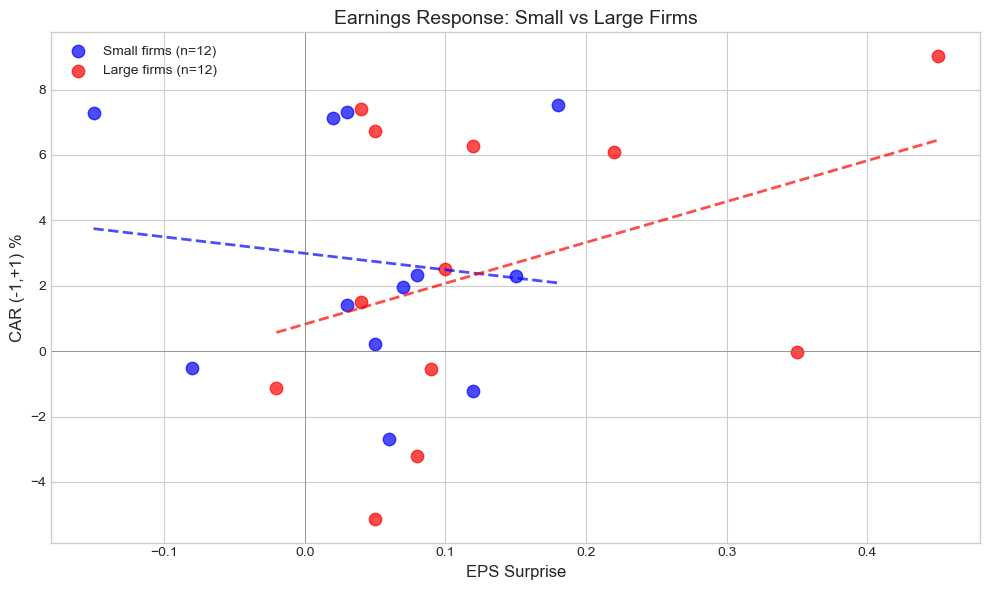


Earnings Response Coefficient:
  Small firms: -0.0503 (-5.03% CAR per unit surprise)
  Large firms: 0.1251 (12.51% CAR per unit surprise)


In [52]:
# Visualize interaction effect
fig, ax = plt.subplots(figsize=(10, 6))

# Split by size (median)
median_mcap = cs_data['log_mcap'].median()
small = cs_data[cs_data['log_mcap'] < median_mcap]
large = cs_data[cs_data['log_mcap'] >= median_mcap]

# Scatter plots
ax.scatter(small['eps_surprise'], small['CAR']*100, color='blue', alpha=0.7, 
           s=80, label=f'Small firms (n={len(small)})')
ax.scatter(large['eps_surprise'], large['CAR']*100, color='red', alpha=0.7, 
           s=80, label=f'Large firms (n={len(large)})')

# Separate regression lines
for data, color, label in [(small, 'blue', 'Small'), (large, 'red', 'Large')]:
    if len(data) > 2:
        z = np.polyfit(data['eps_surprise'], data['CAR']*100, 1)
        p = np.poly1d(z)
        x_line = np.linspace(data['eps_surprise'].min(), data['eps_surprise'].max(), 100)
        ax.plot(x_line, p(x_line), f'{color[0]}--', linewidth=2, alpha=0.7)

ax.axhline(0, color='gray', linestyle='-', linewidth=0.5)
ax.axvline(0, color='gray', linestyle='-', linewidth=0.5)
ax.set_xlabel('EPS Surprise', fontsize=12)
ax.set_ylabel('CAR (-1,+1) %', fontsize=12)
ax.set_title('Earnings Response: Small vs Large Firms', fontsize=14)
ax.legend()

plt.tight_layout()
plt.show()

# Report slope differences
if len(small) > 2 and len(large) > 2:
    slope_small = np.polyfit(small['eps_surprise'], small['CAR'], 1)[0]
    slope_large = np.polyfit(large['eps_surprise'], large['CAR'], 1)[0]
    print(f"\nEarnings Response Coefficient:")
    print(f"  Small firms: {slope_small:.4f} ({slope_small*100:.2f}% CAR per unit surprise)")
    print(f"  Large firms: {slope_large:.4f} ({slope_large*100:.2f}% CAR per unit surprise)")

## 9. Subsample Analysis

### Splitting the Sample

Sometimes relationships differ across subgroups:
- Positive vs negative surprises
- Different sectors
- Different time periods

In [54]:
# Subsample: Positive vs Negative Surprises
print("="*80)
print("SUBSAMPLE ANALYSIS: Positive vs Negative Surprises")
print("="*80)

pos_surprise = cs_data[cs_data['eps_surprise'] > 0]
neg_surprise = cs_data[cs_data['eps_surprise'] <= 0]

print(f"\nPositive surprises: n={len(pos_surprise)}, Mean CAR={pos_surprise['CAR'].mean()*100:.2f}%")
print(f"Negative surprises: n={len(neg_surprise)}, Mean CAR={neg_surprise['CAR'].mean()*100:.2f}%")

# Run regressions on subsamples
if len(pos_surprise) > 5:
    model_pos = run_cross_sectional_regression(pos_surprise, 'CAR', ['eps_surprise', 'log_mcap'])
    print(f"\nPositive Surprise Subsample:")
    print(f"  EPS coefficient: {model_pos.params['eps_surprise']:.4f} (t={model_pos.tvalues['eps_surprise']:.2f})")

if len(neg_surprise) > 5:
    model_neg = run_cross_sectional_regression(neg_surprise, 'CAR', ['eps_surprise', 'log_mcap'])
    print(f"\nNegative Surprise Subsample:")
    print(f"  EPS coefficient: {model_neg.params['eps_surprise']:.4f} (t={model_neg.tvalues['eps_surprise']:.2f})")

SUBSAMPLE ANALYSIS: Positive vs Negative Surprises

Positive surprises: n=21, Mean CAR=2.71%
Negative surprises: n=3, Mean CAR=1.88%

Positive Surprise Subsample:
  EPS coefficient: 0.1402 (t=1.48)


In [56]:
# Subsample: By Sector
print("\n" + "="*80)
print("SUBSAMPLE ANALYSIS: By Sector")
print("="*80)

sector_results = []
for sector in cs_data['sector'].unique():
    sector_data = cs_data[cs_data['sector'] == sector]
    
    if len(sector_data) >= 4:
        try:
            model = run_cross_sectional_regression(sector_data, 'CAR', ['eps_surprise'])
            sector_results.append({
                'Sector': sector,
                'N': len(sector_data),
                'Mean CAR': sector_data['CAR'].mean(),
                'EPS Coef': model.params['eps_surprise'],
                't-stat': model.tvalues['eps_surprise'],
                'R-squared': model.rsquared
            })
        except:
            pass

sector_df = pd.DataFrame(sector_results)
sector_df['Mean CAR'] = sector_df['Mean CAR'].apply(lambda x: f"{x*100:.2f}%")
sector_df['EPS Coef'] = sector_df['EPS Coef'].apply(lambda x: f"{x:.4f}")
sector_df['t-stat'] = sector_df['t-stat'].apply(lambda x: f"{x:.2f}")
sector_df['R-squared'] = sector_df['R-squared'].apply(lambda x: f"{x:.3f}")

print("\nEarnings Response by Sector:")
print(sector_df.to_string(index=False))


SUBSAMPLE ANALYSIS: By Sector

Earnings Response by Sector:
    Sector  N Mean CAR EPS Coef t-stat R-squared
      Tech 10    1.91%   0.2184   2.26     0.389
   Finance  4    4.86%  -0.1867  -1.63     0.572
Healthcare  5    3.91%   0.0405   0.12     0.004
  Consumer  5    0.91%  -0.2298  -1.10     0.286


## 10. Standardized CAR Regressions

### Alternative Approach

Instead of using CAR as dependent variable, use **Standardized CAR** (SCAR):

$$SCAR_i = \frac{CAR_i}{\hat{\sigma}_{CAR_i}}$$

This makes the dependent variable unit-free and comparable across firms with different volatilities.

In [58]:
# Create SCAR variable
cs_data['SCAR'] = cs_data['CAR'] / cs_data['car_se']

print("="*80)
print("SCAR REGRESSION (Standardized Dependent Variable)")
print("="*80)

model_scar = run_cross_sectional_regression(cs_data, 'SCAR', 
                                             ['eps_surprise', 'log_mcap', 'momentum'])
print(model_scar.summary())

SCAR REGRESSION (Standardized Dependent Variable)
                            OLS Regression Results                            
Dep. Variable:                   SCAR   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                 -0.017
Method:                 Least Squares   F-statistic:                    0.8685
Date:                Fri, 23 Jan 2026   Prob (F-statistic):              0.474
Time:                        14:27:18   Log-Likelihood:                -46.455
No. Observations:                  24   AIC:                             100.9
Df Residuals:                      20   BIC:                             105.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

In [60]:
# Compare CAR vs SCAR regressions
print("\n" + "="*70)
print("COMPARISON: CAR vs SCAR as Dependent Variable")
print("="*70)

print("\nNote: SCAR regression gives t-statistics directly comparable to")
print("standardized test statistics from Sessions 4-5.")
print(f"\nMean SCAR in sample: {cs_data['SCAR'].mean():.3f}")
print(f"Std SCAR: {cs_data['SCAR'].std():.3f}")
print(f"\nIf SCAR ~ N(0,1) under null, mean significantly > 0 indicates positive abnormal returns.")


COMPARISON: CAR vs SCAR as Dependent Variable

Note: SCAR regression gives t-statistics directly comparable to
standardized test statistics from Sessions 4-5.

Mean SCAR in sample: 0.985
Std SCAR: 1.821

If SCAR ~ N(0,1) under null, mean significantly > 0 indicates positive abnormal returns.


## 11. Addressing Potential Endogeneity

### The Problem

In some event studies, explanatory variables may be endogenous:

1. **Reverse causality**: Does the event response cause the characteristic?
2. **Omitted variables**: Unobserved factors affecting both X and CAR
3. **Measurement error**: Noisy proxies for true variables

### Example: Earnings Surprise

- Management may manage earnings based on expected market reaction
- Analysts may adjust forecasts based on anticipated news

### Solutions

1. **Use lagged/predetermined variables**: Characteristics measured before event
2. **Instrumental Variables**: Find exogenous instruments
3. **Natural experiments**: Events that are plausibly exogenous

In [63]:
# Demonstrate using pre-determined variables
print("="*80)
print("ADDRESSING ENDOGENEITY: Using Pre-Determined Variables")
print("="*80)

print("\nVariables in our model and their timing:")
print("-" * 60)
print("  eps_surprise:  Realized at event (potentially endogenous)")
print("  log_mcap:      Measured before event (pre-determined)")
print("  momentum:      60-day pre-event return (pre-determined)")
print("  beta:          Estimated from pre-event data (pre-determined)")
print("  sigma:         Estimated from pre-event data (pre-determined)")

# Model using only pre-determined variables
print("\nModel with only pre-determined variables:")
model_predet = run_cross_sectional_regression(cs_data, 'CAR', 
                                               ['log_mcap', 'momentum', 'beta', 'sigma'])
print(f"R-squared: {model_predet.rsquared:.4f}")
print(f"\nNote: Low R-squared without eps_surprise suggests surprise")
print("      is the main driver, as expected for earnings announcements.")

ADDRESSING ENDOGENEITY: Using Pre-Determined Variables

Variables in our model and their timing:
------------------------------------------------------------
  eps_surprise:  Realized at event (potentially endogenous)
  log_mcap:      Measured before event (pre-determined)
  momentum:      60-day pre-event return (pre-determined)
  beta:          Estimated from pre-event data (pre-determined)
  sigma:         Estimated from pre-event data (pre-determined)

Model with only pre-determined variables:
R-squared: 0.1461

Note: Low R-squared without eps_surprise suggests surprise
      is the main driver, as expected for earnings announcements.


## 12. Publication-Ready Results

In [66]:
def create_regression_table(models: List, model_names: List[str], 
                            var_order: List[str]) -> pd.DataFrame:
    """Create publication-style regression table."""
    rows = []
    
    for var in var_order:
        coef_row = {'Variable': var}
        se_row = {'Variable': ''}
        
        for model, name in zip(models, model_names):
            if var in model.params.index:
                coef = model.params[var]
                se = model.bse[var]
                t = model.tvalues[var]
                p = model.pvalues[var]
                
                sig = '***' if p < 0.01 else '**' if p < 0.05 else '*' if p < 0.10 else ''
                coef_row[name] = f"{coef:.4f}{sig}"
                se_row[name] = f"({se:.4f})"
            else:
                coef_row[name] = ''
                se_row[name] = ''
        
        rows.append(coef_row)
        rows.append(se_row)
    
    # Add statistics
    rows.append({'Variable': ''})
    
    r2_row = {'Variable': 'R-squared'}
    n_row = {'Variable': 'N'}
    
    for model, name in zip(models, model_names):
        r2_row[name] = f"{model.rsquared:.3f}"
        n_row[name] = f"{int(model.nobs)}"
    
    rows.append(r2_row)
    rows.append(n_row)
    
    return pd.DataFrame(rows)


# Create table
print("\n" + "="*90)
print("TABLE: Cross-Sectional Determinants of Earnings Announcement Returns")
print("="*90)
print("Dependent Variable: CAR(-1,+1)")
print("-"*90)

models = [model1, model2, model_wls, model_interact]
names = ['(1)', '(2) OLS', '(3) WLS', '(4) Interact']
var_order = ['const', 'eps_surprise', 'log_mcap', 'momentum', 'surprise_x_size']

table = create_regression_table(models, names, var_order)
print(table.to_string(index=False))
print("-"*90)
print("Standard errors in parentheses. *** p<0.01, ** p<0.05, * p<0.10")
print("WLS uses inverse CAR variance as weights.")


TABLE: Cross-Sectional Determinants of Earnings Announcement Returns
Dependent Variable: CAR(-1,+1)
------------------------------------------------------------------------------------------
       Variable      (1)  (2) OLS  (3) WLS (4) Interact
          const  0.0208*   0.1237   0.2094       0.2542
                (0.0104) (0.2718) (0.2810)     (0.3328)
   eps_surprise   0.0596   0.1095   0.1243      -1.1918
                (0.0692) (0.0844) (0.1050)     (1.8653)
       log_mcap           -0.0038  -0.0073      -0.0086
                         (0.0102) (0.0105)     (0.0125)
       momentum           -0.0757  -0.1302      -0.0772
                         (0.0864) (0.1244)     (0.0876)
surprise_x_size                                  0.0469
                                               (0.0672)
                     NaN      NaN      NaN          NaN
      R-squared    0.033    0.098    0.160        0.120
              N       24       24       24           24
------------------------

## 13. Exercises

### Exercise 1: Additional Variables
Add analyst coverage (number of analysts) as an explanatory variable. Does it affect the earnings response?

### Exercise 2: Non-Linear Effects  
Test for non-linear effects by adding squared terms or using splines.

### Exercise 3: Clustered Standard Errors
Implement standard errors clustered by sector or event date.

In [69]:
# Exercise 3: Clustered Standard Errors
print("Exercise 3: Clustered Standard Errors")
print("="*60)

# Cluster by sector
y = cs_data['CAR']
X = sm.add_constant(cs_data[['eps_surprise', 'log_mcap', 'momentum']])

# OLS with clustered SEs by sector
model_cluster = sm.OLS(y, X).fit(cov_type='cluster', 
                                  cov_kwds={'groups': cs_data['sector']})

print("\nOLS with Standard Errors Clustered by Sector:")
print("-"*60)
print(f"{'Variable':<15} {'Coef':>12} {'Clustered SE':>14} {'t-stat':>10}")
print("-"*60)
for var in model_cluster.params.index:
    coef = model_cluster.params[var]
    se = model_cluster.bse[var]
    t = model_cluster.tvalues[var]
    print(f"{var:<15} {coef:>12.6f} {se:>14.6f} {t:>10.2f}")

Exercise 3: Clustered Standard Errors

OLS with Standard Errors Clustered by Sector:
------------------------------------------------------------
Variable                Coef   Clustered SE     t-stat
------------------------------------------------------------
const               0.123684       0.239558       0.52
eps_surprise        0.109478       0.110609       0.99
log_mcap           -0.003781       0.009481      -0.40
momentum           -0.075711       0.059479      -1.27


## 14. Summary

### Key Takeaways

1. **Cross-sectional analysis** reveals why events affect firms differently

2. **Heteroskedasticity** is common in event studies; use robust SEs or WLS

3. **WLS with inverse variance weights** is efficient when variance structure is known

4. **Check for multicollinearity** using VIF before interpreting coefficients

5. **Interaction effects** can reveal whether relationships vary across subgroups

6. **Endogeneity** may bias results; use pre-determined variables when possible

### Best Practices

- Report both OLS and robust SEs
- Consider WLS when variance estimates are reliable
- Test for heteroskedasticity explicitly
- Run subsample analyses for robustness
- Be cautious about endogeneity in event characteristics

### Coming Up Next

**Session 7: Long-Horizon Event Studies** will cover:
- Calendar-time portfolio approach
- Buy-and-hold abnormal returns (BHAR)
- Dealing with overlapping events
- Power issues in long-horizon studies

## References

- White, H. (1980). A heteroskedasticity-consistent covariance matrix estimator and a direct test for heteroskedasticity. *Econometrica*, 48(4), 817-838.
- MacKinnon, J. G., & White, H. (1985). Some heteroskedasticity-consistent covariance matrix estimators with improved finite sample properties. *Journal of Econometrics*, 29(3), 305-325.
- Kothari, S. P., & Warner, J. B. (2007). Econometrics of event studies. *Handbook of Corporate Finance*, 1, 3-36.
- Prabhala, N. R. (1997). Conditional methods in event studies and an equilibrium justification for standard event-study procedures. *Review of Financial Studies*, 10(1), 1-38.